# 7. Multilevel GLM (from Nilearn)

In this tutorial, we demonstrate how to write pydra tasks for the first and second level GLM in Nilearn. We use the data from [Balloon Analog Risk-taking Task](https://openneuro.org/datasets/ds000001/versions/1.0.0). 
Basic information about this dataset:
- 16 subjects
- 3 runs
- functional scan TR: 2.3 
- num of functional scan: 300

In [1]:
import nest_asyncio
nest_asyncio.apply()

## Preparation

Import packages that will be used globally and set up output directory

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import os, glob
import datetime
import random
import pydra
from pydra import Workflow
from pydra.engine.specs import File, MultiInputFile, MultiOutputFile
import typing as ty
from pathlib import Path

# get current directory
pydra_tutorial_dir = os.path.dirname(os.getcwd())

# set up output directory
workflow_dir = Path(pydra_tutorial_dir) / 'outputs'
workflow_out_dir = workflow_dir / '7_glm' /'results'

# create the output directory if not exit
os.makedirs(workflow_out_dir, exist_ok=True)

A newer version (0.19) of nipype/pydra is available. You are using 0.18+68.g943ac89.dirty


## Download the data

[DataLad](http://handbook.datalad.org/en/latest/index.htmlhttp://handbook.datalad.org/en/latest/index.html) is often used in those cases to download data. Here we use its [Python API](http://docs.datalad.org/en/latest/modref.htmlhttp://docs.datalad.org/en/latest/modref.html).

We need the following data: 

1. event information (raw data)
2. preprocessed image data (fmriprep)
3. confounds (fmriprep)

By `datalad.api.install`, datalad downloads all symlinks without storing the actual data locally. We can then use `datalad.api.get` to get the data we need for our analysis. 
We need to get four types of data from two folders:

1. event_info: `*events.tsv` from `rawdata_path`
2. bold: `*space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz` from `fmriprep_path`
3. mask: `*space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz` from `fmriprep_path`
4. confounds: `*desc-confounds_timeseries.tsv` from `fmriprep_path` (this is implicitly needed by `load_confounds_strategy`)

In [3]:
fmriprep_path = workflow_out_dir / 'data'
rawdata_path = workflow_out_dir / 'raw_data'

In [4]:
@pydra.mark.task
@pydra.mark.annotate(
    {
        'rawdata_url': str,
        'fmriprep_url': str,
        'return': {'event_list': MultiOutputFile, 
                   'img_list': MultiOutputFile, 
                   'mask_list': MultiOutputFile, 
                  },
    }
)
def get_data(rawdata_url, fmriprep_url):
    print("Download data...")
    t1 = datetime.datetime.now()
    print(t1)
    import datalad.api as dl
    fmriprep_path = workflow_dir / '7_glm'/ 'data'
    rawdata_path = workflow_dir / '7_glm' / 'raw_data'
    
    # Install datasets to specific datapaths
    dl.install(source=rawdata_url, path=fmriprep_path)
    dl.install(source=fmriprep_url, path=rawdata_path)
    
    # get events.tsv list
    event_list = glob.glob(os.path.join(rawdata_path, '*', 'func', '*events.tsv'))
    event_list.sort()
    for i in event_list:
        dl.get(i, dataset=rawdata_path)
    # get img list
    img_list = glob.glob(os.path.join(fmriprep_path, '*', 'func', '*space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz'))
    img_list.sort()
    for i in img_list:
        dl.get(i, dataset=fmriprep_path)
    # get img list
    mask_list = glob.glob(os.path.join(fmriprep_path, '*', 'func', '*space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz'))
    mask_list.sort()
    for i in mask_list:
        dl.get(i, dataset=fmriprep_path)
    # get confounds list
    confound_list = glob.glob(os.path.join(fmriprep_path, '*', 'func', '*desc-confounds_timeseries.tsv'))
    confound_list.sort()
    for i in mask_list:
        dl.get(i, dataset=fmriprep_path)
    
    return event_list, img_list, mask_list

## First-Level GLM

We conduct the first level GLM for each run on every subject.

### Get events, preproc_bold, and masks for each subject

each subject will have a list of three (run) of those files

In [5]:
@pydra.mark.task
@pydra.mark.annotate(
    {
        'subj_id': int,
        'n_run': int,
        'event_list': list, 
        'img_list': list, 
        'mask_list': list,
        'return': {'subj_id': int, 'subj_events': list, 'subj_imgs':list, 'subj_masks':list},
    }
)
def get_subj_file(subj_id, n_run, event_list, img_list, mask_list):
    print(f"\nGet subject-{subj_id+1} file...\n")
    # subj_id starts from 0
    start = subj_id*n_run
    end = (subj_id+1)*n_run
    subj_events = event_list[start:end]
    subj_imgs = img_list[start:end]
    subj_masks = mask_list[start:end]
    return subj_id, subj_events, subj_imgs, subj_masks

### Get the first-level design matrix

The design matrix is a _M(row)_ x _N(columns)_ matrix. _M_ corresponds to the number of _tr_, while _N_ corresponds to event conditions + confounds.

In [6]:
@pydra.mark.task
@pydra.mark.annotate(
    {
        'tr': float,
        'n_scans': int,
        'hrf_model': str,
        'subj_id': int,
        'subj_imgs': list,
        'subj_events':list,
        'return': {'design_matrices': list, 'dm_paths':list},
    }
)
def get_firstlevel_dm(tr, n_scans, hrf_model, subj_id, subj_imgs, subj_events):
    print(f"\nGet subject-{subj_id+1} firstlevel GLM ...\n")
    import numpy as np
    import pandas as pd
    from nilearn.glm.first_level import make_first_level_design_matrix
    from nilearn.interfaces.fmriprep import load_confounds_strategy
    # read event file
    events = []
    imgs = []
    for run_event in subj_events:
        event = pd.read_csv(run_event, sep='\t').fillna(0)
        event = event[['onset', 'duration', 'trial_type']]
        events.append(event)
    
    # get list of confounds directly from fmriprepped bold
    confounds = load_confounds_strategy(subj_imgs, denoise_strategy='simple')[0]
    
    frame_times = np.arange(n_scans) * tr
    design_matrices = []
    dm_paths = []
    for index, (ev, conf) in enumerate(zip(events, confounds)):
        design_matrix = make_first_level_design_matrix(frame_times, ev, 
                                                       hrf_model=hrf_model,
                                                       add_regs=conf)          
        
        # make sure all design matrices have the same length of column
        # if you have a block design, this is not needed.
        # 39 = 4(events) + 34(confounds) + 13(drift) + 1(constant)
        assert design_matrix.shape[1] == 52, "This design matrix has the wrong column number"
        # sort the column order alphabetical for contrasts
        design_matrix = design_matrix.reindex(sorted(design_matrix.columns), axis=1)
        dm_path = os.path.join(workflow_out_dir, 'sub-%s_run-%s_designmatrix.csv' % (subj_id+1, index+1))
        design_matrix.to_csv(dm_path, index=None)
        design_matrices.append(design_matrix)
        dm_paths.append(dm_path)
    return design_matrices, dm_paths

### Set up the first-level contrasts

In [7]:
@pydra.mark.task
@pydra.mark.annotate(
    {
        'subj_id': int,
        'design_matrices': list,
        'return': {'contrasts': dict},
    }
)
def set_contrast(subj_id, design_matrices):
    t1 = datetime.datetime.now()
    print(f"\nSet firstlevel contrast for subject-{subj_id+1} ...\n")
    
    import pandas as pd
    import numpy as np
    
    design_matrix = design_matrices[0]
    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i])
                      for i, column in enumerate(design_matrix.columns)])
    contrasts = {
        'pumps-control': basic_contrasts['pumps_demean'] - basic_contrasts['control_pumps_demean'],
        'control-pumps': -basic_contrasts['control_pumps_demean'] + basic_contrasts['pumps_demean'],
        'pumps-baseline': basic_contrasts['pumps_demean'],
        'cash-baseline': basic_contrasts['cash_demean'],
        'explode-baseline': basic_contrasts['explode_demean']
        }
    return contrasts

### Fit the first level GLM with fixed-effects

In [8]:
@pydra.mark.task
@pydra.mark.annotate(
    {
        'subj_id': int,
        'subj_imgs': MultiInputFile,
        'subj_masks': MultiInputFile,
        'smoothing_fwhm': float,
        'design_matrices': list,
        'contrasts':dict,
        'return': {'z_map_path_dict': dict},
    }
)
def firstlevel_estimation(subj_id, subj_imgs, subj_masks, smoothing_fwhm, design_matrices, contrasts):
    print(f"\nStart firstlevel estimation for subject-{subj_id+1} ...\n")
    import nibabel as nib
    from nilearn.image import math_img
    from nilearn.glm.first_level import FirstLevelModel
    print('Compute firstlevel mask...')
    # average mask across three runs
    mean_mask = math_img('np.mean(img, axis=-1)', img=subj_masks)
    # binarize the mean mask
    mask = math_img('img > 0', img=mean_mask)
    print('Fit the firstlevel model...')
    # fit the (fixed-effects) firstlevel model with three runs simultaneously
    first_level_model = FirstLevelModel(mask_img=mask, smoothing_fwhm=smoothing_fwhm)
    first_level_model = first_level_model.fit(subj_imgs, design_matrices=design_matrices)
    
    print('Computing contrasts...')
    z_map_path_dict = dict.fromkeys(contrasts.keys())
    for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
        print('  Contrast % 2i out of %i: %s' % (
            index + 1, len(contrasts), contrast_id))
        # Estimate the contasts. Note that the model implicitly computes a fixed
        # effect across the two sessions
        z_map = first_level_model.compute_contrast(
            contrast_val, output_type='z_score')

        # write the resulting stat images to file
        z_map_path = os.path.join(workflow_out_dir, 'sub-%s_contrast-%s_z_map.nii.gz' % (subj_id+1, contrast_id))
        z_map_path_dict[contrast_id] = z_map_path
        z_map.to_filename(z_map_path)
    return z_map_path_dict

### Create the first-level GLM workflow

In [9]:
# initiate the first-level GLM workflow
wf_firstlevel = Workflow(
    name='wf_firstlevel',
    input_spec=[
        'subj_id',
        'n_run',
        'tr',
        'n_scans',
        'hrf_model',
        'event_list', 
        'img_list', 
        'mask_list',
        'smoothing_fwhm',
        'output_dir'
    ],
)

wf_firstlevel.split('subj_id')
# add task - get_subj_file
wf_firstlevel.add(
    get_subj_file(
        name = "get_subj_file",
        subj_id = wf_firstlevel.lzin.subj_id, 
        n_run = wf_firstlevel.lzin.n_run, 
        event_list = wf_firstlevel.lzin.event_list, 
        img_list = wf_firstlevel.lzin.img_list, 
        mask_list = wf_firstlevel.lzin.mask_list
    )
)

# add task - get_firstlevel_dm
wf_firstlevel.add(
    get_firstlevel_dm(
        name = "get_firstlevel_dm",
        tr = wf_firstlevel.lzin.tr, 
        n_scans = wf_firstlevel.lzin.n_scans, 
        hrf_model = wf_firstlevel.lzin.hrf_model, 
        subj_id = wf_firstlevel.get_subj_file.lzout.subj_id, 
        subj_imgs = wf_firstlevel.get_subj_file.lzout.subj_imgs, 
        subj_events = wf_firstlevel.get_subj_file.lzout.subj_events, 
    )
)

# add task - set_contrast
wf_firstlevel.add(
    set_contrast(
        name = "set_contrast",
        subj_id = wf_firstlevel.get_subj_file.lzout.subj_id,
        design_matrices = wf_firstlevel.get_firstlevel_dm.lzout.design_matrices
    )
)

# add task - firstlevel_estimation
wf_firstlevel.add(
    firstlevel_estimation(
        name = "firstlevel_estimation",
        subj_id = wf_firstlevel.get_subj_file.lzout.subj_id, 
        subj_imgs = wf_firstlevel.get_subj_file.lzout.subj_imgs, 
        subj_masks = wf_firstlevel.get_subj_file.lzout.subj_masks, 
        smoothing_fwhm = wf_firstlevel.lzin.smoothing_fwhm, 
        design_matrices = wf_firstlevel.get_firstlevel_dm.lzout.design_matrices, 
        contrasts = wf_firstlevel.set_contrast.lzout.contrasts
    )
)

wf_firstlevel.combine('subj_id')
# specify output
wf_firstlevel.set_output(
    [
        ('first_level_contrast', wf_firstlevel.set_contrast.lzout.contrasts),
        ('first_level_z_map_list', wf_firstlevel.firstlevel_estimation.lzout.z_map_path_dict),
    ]
)

## Second-Level GLM

The second-level estimation contains the following steps:
- construct design matrix
- fit the second-level GLM
- statistical testing

### Get second-level design matrix

This is a one-group design. So we need a design matrix for a one-sample test.

The design matrix is a single column of ones, corresponding to the model intercept.

In [10]:
@pydra.mark.task
@pydra.mark.annotate(
    {'n_subj': int, 'return': {'design_matrix': ty.Any}}
)
def get_secondlevel_dm(n_subj):
    t1 = datetime.datetime.now()
    print(f"\nGet secondlevel design matrix ...\n")
    import pandas as pd
    design_matrix = pd.DataFrame([1] * n_subj,columns=['intercept'])
    return design_matrix

### Fit the second level GLM

Here, we use the list of FirstLevel z-maps as the input for the SecondLevelModel.

In [11]:
@pydra.mark.task
@pydra.mark.annotate(
    {'firstlevel_zmap_list': list, 'design_matrix': ty.Any, 'firstlevel_contrast':list, 
     'return': {'secondlevel_mask': ty.Any, 'stat_maps_dict': dict}}
)
def secondlevel_estimation(firstlevel_zmap_list, design_matrix, firstlevel_contrast):
    import nibabel as nib
    from nilearn.glm.second_level import SecondLevelModel
    print(f"\nStart secondlevel estimation ...\n")
    stat_maps_dict = dict.fromkeys(firstlevel_contrast[0].keys())
    for index, (contrast_id, contrast_val) in enumerate(firstlevel_contrast[0].items()):
        print(' Contrast % 2i out of %i: %s' % (
            index + 1, len(firstlevel_contrast[0]), contrast_id))
        second_level_input = [nib.load(z_map_dict[contrast_id]) for z_map_dict in firstlevel_zmap_list]
        
        second_level_model = SecondLevelModel()
        second_level_model = second_level_model.fit(second_level_input, design_matrix=design_matrix)
        secondlevel_mask = second_level_model.masker_.mask_img_
    
        stats = second_level_model.compute_contrast(output_type='all')
        # write the resulting stat images to file
        z_image_path = os.path.join(workflow_out_dir, 'secondlevel_contrast-%s_z_map.nii.gz' % contrast_id)
        stat_maps_dict[contrast_id] = stats
        stats['z_score'].to_filename(z_image_path)
    return secondlevel_mask, stat_maps_dict

### Create the second-level GLM workflow

In [12]:
# initiate the first-level GLM workflow
wf_secondlevel = Workflow(
    name='wf_secondlevel',
    input_spec=[
        'n_subj',
        'firstlevel_zmap_list', 
        'firstlevel_contrast',
        'n_perm',
    ],
)

# add task - get_secondlevel_dm
wf_secondlevel.add(
    get_secondlevel_dm(
        name = "get_secondlevel_dm",
        n_subj = wf_secondlevel.lzin.n_subj, 
    )
)

# add task - secondlevel_estimation
wf_secondlevel.add(
    secondlevel_estimation(
        name = "secondlevel_estimation",
        firstlevel_zmap_list = wf_secondlevel.lzin.firstlevel_zmap_list,  
        design_matrix = wf_secondlevel.get_secondlevel_dm.lzout.design_matrix, 
        firstlevel_contrast = wf_secondlevel.lzin.firstlevel_contrast
    )
)

# specify output
wf_secondlevel.set_output(
    [
        ('second_level_designmatrix', wf_secondlevel.get_secondlevel_dm.lzout.design_matrix),
        ('second_level_mask', wf_secondlevel.secondlevel_estimation.lzout.secondlevel_mask),
        ('second_level_stats_map', wf_secondlevel.secondlevel_estimation.lzout.stat_maps_dict)
    ]
)

## Statistical Testing

In this section, we present different ways of doing statistical testing

1. Cluster-thresholding without multiple comparison
2. Multiple comparison using FDR
3. Paramatric testing
4. Nonparamatric testing

### Cluster-thresholding and Plot without multiple comparison

Threshold the resulting map without multiple comparisons correction, abs(z) > 3.29 (equivalent to p < 0.001), cluster size > 10 voxels.

In [13]:
@pydra.mark.task
@pydra.mark.annotate(
    {'stat_maps_dict': dict, 'threshold': float, 'cluster_threshold': int, 
     'return': {'thresholded_map_dict': dict, 'plot_contrast_dict': dict}}
)
def cluster_thresholding(stat_maps_dict, threshold, cluster_threshold):
    t1 = datetime.datetime.now()
    print("\nStart cluster thresholding ...\n")
    from nilearn.image import threshold_img
    from nilearn.plotting import plot_stat_map
    thresholded_map_dict = dict.fromkeys(stat_maps_dict.keys())
    plot_contrast_dict = dict.fromkeys(stat_maps_dict.keys())
    for index, (stats_id, stats_val) in enumerate(stat_maps_dict.items()):
        print('Contrast % 2i out of %i: %s' % (
            index + 1, len(stat_maps_dict), stats_id))
        thresholded_map = threshold_img(
            img = stats_val['z_score'],
            threshold=threshold,
            cluster_threshold=cluster_threshold,
            two_sided=True,
        )
        thresholded_map_path = os.path.join(workflow_out_dir, 'secondlevel_cluster_thresholded_contrast-%s_z_map.nii.gz' % stats_id)
        thresholded_map_dict[stats_id] = thresholded_map_path
        thresholded_map.to_filename(thresholded_map_path)
        plot_path = os.path.join(workflow_out_dir, 
                                   'secondlevel_cluster_thresholded_contrast-%s_zmap.jpg' % stats_id)
        plot_contrast_dict[stats_id] = plot_path
        plot_stat_map(thresholded_map,
                               title='Cluster Thresholded z map',
                               output_file=plot_path)
    print("\nCluster thresholding is done")
    return thresholded_map_dict, plot_contrast_dict

### Multiple comparison and Plot

We have the following choices:
- `fdr`: False Discovery Rate (FDR <.05) and no cluster-level threshold
- `fpr`: False Positive Rate
- `bonferroni`

More details see [here](https://nilearn.github.io/stable/modules/generated/nilearn.glm.threshold_stats_img.html#nilearn.glm.threshold_stats_img)

In [14]:
@pydra.mark.task
@pydra.mark.annotate(
    {'stat_maps_dict': dict, 'alpha': float, 'height_control': str, 
     'return': {'thresholded_map_dict': dict, 'plot_contrast_dict': dict}}
)
def multiple_comparison(stat_maps_dict, alpha, height_control):
    print("\nStart multiple comparison ...\n")
    from nilearn.glm import threshold_stats_img
    from nilearn.plotting import plot_stat_map
    thresholded_map_dict = dict.fromkeys(stat_maps_dict.keys())
    plot_contrast_dict = dict.fromkeys(stat_maps_dict.keys())
    for index, (stats_id, stats_val) in enumerate(stat_maps_dict.items()):
        print('Contrast % 2i out of %i: %s' % (
            index + 1, len(stat_maps_dict), stats_id))
        thresholded_map, threshold = threshold_stats_img(
            stat_img=stats_val['z_score'], 
            alpha=alpha, 
            height_control=height_control)
        thresholded_map_path = os.path.join(workflow_out_dir, 
                                         'secondlevel_multiple_comp_corrected_contrast-%s_z_map.nii.gz' % stats_id)
        thresholded_map_dict[stats_id] = thresholded_map_path
        thresholded_map.to_filename(thresholded_map_path)
        plot_path = os.path.join(workflow_out_dir, 
                                   'secondlevel_multiple_comp_corrected_contrast-%s_zmap.jpg' % stats_id)
        plot_contrast_dict[stats_id] = plot_path
        plot_stat_map(thresholded_map,
                      title='Thresholded z map, expected fdr = .05',
                      threshold=threshold, 
                      output_file=plot_path)
    print("\nMultiple comparison is done")
    return thresholded_map_dict, plot_contrast_dict

### Paramatric test & Plot

We threshold the second level contrast at uncorrected p < 0.001.

A nilearn example see [here](https://nilearn.github.io/dev/auto_examples/05_glm_second_level/plot_second_level_one_sample_test.html)

In [15]:
@pydra.mark.task
@pydra.mark.annotate(
    {'stat_maps_dict': dict, 
     'secondlevel_mask': ty.Any,
     'return': {'thresholded_map_dict': dict, 'plot_contrast_dict': dict}}
)
def parametric_test(stat_maps_dict, secondlevel_mask):
    print("\nStart parametric test ...\n")
    import numpy as np
    from nilearn.image import get_data, math_img
    from nilearn.plotting import plot_stat_map
    thresholded_map_dict = dict.fromkeys(stat_maps_dict.keys())
    plot_contrast_dict = dict.fromkeys(stat_maps_dict.keys())
    for index, (stats_id, stats_val) in enumerate(stat_maps_dict.items()):
        print('Contrast % 2i out of %i: %s' % (
            index + 1, len(stat_maps_dict), stats_id))
        p_val = stats_val['p_value']
        n_voxels = np.sum(get_data(secondlevel_mask))
        # Correcting the p-values for multiple testing and taking negative logarithm
        neg_log_pval = math_img("-np.log10(np.minimum(1, img * {}))"
                                .format(str(n_voxels)),
                                img=p_val)
        
        thresholded_map_path = os.path.join(workflow_out_dir, 'secondlevel_paramatric_thresholded_contrast-%s_z_map.nii.gz' % stats_id)
        thresholded_map_dict[stats_id] = thresholded_map_path
        neg_log_pval.to_filename(thresholded_map_path)
    
        # Since we are plotting negative log p-values and using a threshold equal to 1,
        # it corresponds to corrected p-values lower than 10%, meaning that there is
        # less than 10% probability to make a single false discovery (90% chance that
        # we make no false discovery at all).  This threshold is much more conservative
        # than the previous one.
        title = ('parametric test (FWER < 10%)')
        plot_path = os.path.join(workflow_out_dir, 
                                   'secondlevel_paramatric_thresholded_contrast-%s_zmap.jpg' % stats_id)
        plot_contrast_dict[stats_id] = plot_path
        plot_stat_map(
            neg_log_pval, colorbar=True,
            title=title, output_file=plot_path)
    print("\nParametric test is done")
    return thresholded_map_dict, plot_contrast_dict

### Non-paramatric test & Plot

Here we compute the (corrected) negative log p-values with permutation test.

In [16]:
@pydra.mark.task
@pydra.mark.annotate(
    {'firstlevel_zmap_list': list, 'smoothing_fwhm':float,'design_matrix': ty.Any, 'firstlevel_contrast': list, 'n_perm': int, 
     'return': {'thresholded_map_dict': dict, 'plot_contrast_dict': dict}}
)
def nonparametric_test(firstlevel_zmap_list, smoothing_fwhm, design_matrix, firstlevel_contrast, n_perm):
    print(f"\nStart nonparametric test ...\n")
    import nibabel as nib
    from nilearn.glm.second_level import non_parametric_inference
    from nilearn.plotting import plot_stat_map
    thresholded_map_dict = dict.fromkeys(firstlevel_contrast[0].keys())
    plot_contrast_dict = dict.fromkeys(firstlevel_contrast[0].keys())
    for index, (contrast_id, contrast_val) in enumerate(firstlevel_contrast[0].items()):
        print('  Contrast % 2i out of %i: %s' % (
            index + 1, len(firstlevel_contrast[0]), contrast_id))
        # here we set threshold as none to do voxel-level FWER-correction.
        second_level_input = [nib.load(z_map_dict[contrast_id]) for z_map_dict in firstlevel_zmap_list]
        neg_log_pvals_permuted_ols_unmasked = \
            non_parametric_inference(second_level_input=second_level_input, design_matrix=design_matrix,
                                     model_intercept=True, n_perm=n_perm,
                                     two_sided_test=False, smoothing_fwhm=smoothing_fwhm, n_jobs=1)
        thresholded_map_path = os.path.join(workflow_out_dir, 'secondlevel_permutation_contrast-%s_z_map.nii.gz' % contrast_id)
        thresholded_map_dict[contrast_id] = thresholded_map_path
        neg_log_pvals_permuted_ols_unmasked.to_filename(thresholded_map_path)
        # here I actually have more than one contrast
        title = ('permutation test (FWER < 10%)')
        plot_path = os.path.join(workflow_out_dir, 'secondlevel_permutation_contrast-%s_zmap.jpg' % contrast_id)
        plot_contrast_dict[contrast_id] = plot_path
        plot_stat_map(
            neg_log_pvals_permuted_ols_unmasked, colorbar=True, 
            title=title, output_file=plot_path)
    print("\nPermutation is done")
    return thresholded_map_dict, plot_contrast_dict

## The Ultimate Workflow

Now, let's connect all tasks and workflows together.

Here we randomly choose **5** subjects to perform the analysis. 

For computational time, we set `n_perm=`.

In [17]:
wf = Workflow(
    name='twolevel_glm',
    input_spec=['subj_id', 'rawdata_url', 'fmriprep_url'],
)

wf.inputs.rawdata_url = 'https://github.com/OpenNeuroDerivatives/ds000001-fmriprep.git'
wf.inputs.fmriprep_url = 'https://github.com/OpenNeuroDatasets/ds000001.git'

wf.add(
    get_data(
        name = "get_data",
        rawdata_url = wf.lzin.rawdata_url, 
        fmriprep_url = wf.lzin.fmriprep_url)
)

n_subj = 5


# randomly choose subjects
wf_firstlevel.inputs.subj_id = random.sample(range(16), n_subj)
wf_firstlevel.inputs.n_run = 3
wf_firstlevel.inputs.tr = 2.3
wf_firstlevel.inputs.n_scans = 300
wf_firstlevel.inputs.hrf_model = 'glover'
wf_firstlevel.inputs.event_list = wf.get_data.lzout.event_list
wf_firstlevel.inputs.img_list = wf.get_data.lzout.img_list
wf_firstlevel.inputs.mask_list = wf.get_data.lzout.mask_list
wf_firstlevel.inputs.smoothing_fwhm = 5.0
wf.add(wf_firstlevel)

wf_secondlevel.inputs.n_subj = n_subj
wf_secondlevel.inputs.firstlevel_zmap_list = wf.wf_firstlevel.lzout.first_level_z_map_list 
wf_secondlevel.inputs.firstlevel_contrast = wf.wf_firstlevel.lzout.first_level_contrast
wf.add(wf_secondlevel)

# add task - cluster_thresholding
wf.add(
    cluster_thresholding(
        name = "cluster_thresholding",
        stat_maps_dict = wf.wf_secondlevel.lzout.second_level_stats_map, 
        threshold = 3.29, 
        cluster_threshold = 10
    )
)


# add task - multiple_comparison
wf.add(
    multiple_comparison(
        name = "multiple_comparison",
        stat_maps_dict = wf.wf_secondlevel.lzout.second_level_stats_map, 
        alpha = 0.05,
        height_control = 'fdr'
    )
)

# add task - parametric_test
wf.add(
    parametric_test(
        name = "parametric_test",
        stat_maps_dict =  wf.wf_secondlevel.lzout.second_level_stats_map, 
        secondlevel_mask = wf.wf_secondlevel.lzout.second_level_mask
    )
    
)

# add task - nonparametric_test
wf.add(
    nonparametric_test(
        name = "nonparametric_test",
        firstlevel_zmap_list = wf.wf_firstlevel.lzout.first_level_z_map_list,
        smoothing_fwhm = 5.0,
        design_matrix = wf.wf_secondlevel.lzout.second_level_designmatrix,
        firstlevel_contrast = wf.wf_firstlevel.lzout.first_level_contrast,
        n_perm = 1,
    )
)

wf.set_output(
    [
        ('second_level_stats_map', wf.wf_secondlevel.lzout.second_level_stats_map)   
    ]
)

In [18]:
from pydra import Submitter

with Submitter(plugin='cf', n_procs=8) as submitter:
    submitter(wf)

results = wf.result()

print(results)

Download data...
2022-08-31 20:58:45.929328

Get subject-11 file...

Get subject-14 file...

Get subject-6 file...




Get subject-16 file...

Get subject-5 file...



Get subject-11 firstlevel GLM ...


Get subject-16 firstlevel GLM ...

Get subject-5 firstlevel GLM ...



Get subject-6 firstlevel GLM ...


Get subject-14 firstlevel GLM ...



/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)
/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)
/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)
/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'I


Set firstlevel contrast for subject-5 ...


Set firstlevel contrast for subject-16 ...


Set firstlevel contrast for subject-11 ...


Set firstlevel contrast for subject-6 ...


Set firstlevel contrast for subject-14 ...


Start firstlevel estimation for subject-5 ...

Compute firstlevel mask...

Start firstlevel estimation for subject-16 ...

Compute firstlevel mask...
Fit the firstlevel model...
Fit the firstlevel model...

Start firstlevel estimation for subject-11 ...

Start firstlevel estimation for subject-6 ...


Compute firstlevel mask...Compute firstlevel mask...


Start firstlevel estimation for subject-14 ...

Compute firstlevel mask...
Fit the firstlevel model...Fit the firstlevel model...

Fit the firstlevel model...
Computing contrasts...
  Contrast  1 out of 5: pumps-control


/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:657: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


  Contrast  2 out of 5: control-pumps
  Contrast  3 out of 5: pumps-baseline
  Contrast  4 out of 5: cash-baseline
  Contrast  5 out of 5: explode-baseline
Computing contrasts...
  Contrast  1 out of 5: pumps-control


/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:657: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


  Contrast  2 out of 5: control-pumps
Computing contrasts...
  Contrast  1 out of 5: pumps-control


/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:657: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Computing contrasts...
  Contrast  1 out of 5: pumps-control


/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:657: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Computing contrasts...
  Contrast  1 out of 5: pumps-control


/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:657: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


  Contrast  3 out of 5: pumps-baseline
  Contrast  2 out of 5: control-pumps
  Contrast  4 out of 5: cash-baseline
  Contrast  2 out of 5: control-pumps
  Contrast  2 out of 5: control-pumps
  Contrast  5 out of 5: explode-baseline
  Contrast  3 out of 5: pumps-baseline
  Contrast  3 out of 5: pumps-baseline
  Contrast  3 out of 5: pumps-baseline
  Contrast  4 out of 5: cash-baseline
  Contrast  4 out of 5: cash-baseline
  Contrast  4 out of 5: cash-baseline
  Contrast  5 out of 5: explode-baseline
  Contrast  5 out of 5: explode-baseline
  Contrast  5 out of 5: explode-baseline

Get secondlevel design matrix ...



/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)



Start secondlevel estimation ...

 Contrast  1 out of 5: pumps-control
 Contrast  2 out of 5: control-pumps
 Contrast  3 out of 5: pumps-baseline
 Contrast  4 out of 5: cash-baseline
 Contrast  5 out of 5: explode-baseline

Start cluster thresholding ...

Contrast  1 out of 5: pumps-control


/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()
/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:68: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  .format(DEFAULT_CUT_COORDS))



Start multiple comparison ...



/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/plotting/displays/_slicers.py:383: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


Contrast  2 out of 5: control-pumps
Contrast  1 out of 5: pumps-control


/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/_utils/param_validation.py:74: UserWarning: The given float value must not exceed 4.694226914112399. But, you have given threshold=inf 
  threshold))
/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


Contrast  3 out of 5: pumps-baseline


/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:68: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  .format(DEFAULT_CUT_COORDS))


Contrast  4 out of 5: cash-baseline


/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/plotting/displays/_slicers.py:383: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


Contrast  2 out of 5: control-pumps


/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/_utils/param_validation.py:74: UserWarning: The given float value must not exceed 4.694226914112399. But, you have given threshold=inf 
  threshold))


Contrast  3 out of 5: pumps-baseline
Contrast  5 out of 5: explode-baseline


/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/_utils/param_validation.py:74: UserWarning: The given float value must not exceed 4.574085283336893. But, you have given threshold=inf 
  threshold))



Start nonparametric test ...


Start parametric test ...

Contrast  4 out of 5: cash-baseline


/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/_utils/param_validation.py:74: UserWarning: The given float value must not exceed 4.490033793169723. But, you have given threshold=inf 
  threshold))



Cluster thresholding is done
  Contrast  1 out of 5: pumps-control
Contrast  1 out of 5: pumps-control


<string>:1: RuntimeWarning: divide by zero encountered in log10
/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()
/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/mass_univariate/permuted_least_squares.py:504: UserWarning: The specified number of permutations is 1 and the number of jobs to be performed in parallel has set to 1. This is incompatible so only 1 jobs will be running. You may want to perform more permutations in order to take the most of the available computing ressources.
  'ressources.' % (n_perm, n_jobs, n_perm))


Contrast  5 out of 5: explode-baseline


/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()
/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/_utils/param_validation.py:74: UserWarning: The given float value must not exceed 4.60634680224833. But, you have given threshold=inf 
  threshold))
/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/_utils/niimg.py:62: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  "Non-finite values detected. "



Multiple comparison is done
Contrast  2 out of 5: control-pumps


<string>:1: RuntimeWarning: divide by zero encountered in log10


  Contrast  2 out of 5: control-pumps
Contrast  3 out of 5: pumps-baseline


<string>:1: RuntimeWarning: divide by zero encountered in log10
/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/mass_univariate/permuted_least_squares.py:504: UserWarning: The specified number of permutations is 1 and the number of jobs to be performed in parallel has set to 1. This is incompatible so only 1 jobs will be running. You may want to perform more permutations in order to take the most of the available computing ressources.
  'ressources.' % (n_perm, n_jobs, n_perm))
/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:68: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  .format(DEFAULT_CUT_COORDS))


Contrast  4 out of 5: cash-baseline


<string>:1: RuntimeWarning: divide by zero encountered in log10
/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:68: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  .format(DEFAULT_CUT_COORDS))
/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/plotting/displays/_slicers.py:383: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


  Contrast  3 out of 5: pumps-baseline


/Users/yibeichen/miniconda3/envs/pydra/lib/python3.7/site-packages/nilearn/plotting/displays/_slicers.py:383: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


Contrast  5 out of 5: explode-baseline


<string>:1: RuntimeWarning: divide by zero encountered in log10



Parametric test is done
  Contrast  4 out of 5: cash-baseline
  Contrast  5 out of 5: explode-baseline

Permutation is done
Result(output=Output(second_level_stats_map={'pumps-control': {'z_score': <nibabel.nifti1.Nifti1Image object at 0x7ff230a10cd0>, 'stat': <nibabel.nifti1.Nifti1Image object at 0x7ff210794f90>, 'p_value': <nibabel.nifti1.Nifti1Image object at 0x7ff2107940d0>, 'effect_size': <nibabel.nifti1.Nifti1Image object at 0x7ff210792b50>, 'effect_variance': <nibabel.nifti1.Nifti1Image object at 0x7ff210792490>}, 'control-pumps': {'z_score': <nibabel.nifti1.Nifti1Image object at 0x7ff210792110>, 'stat': <nibabel.nifti1.Nifti1Image object at 0x7ff2107921d0>, 'p_value': <nibabel.nifti1.Nifti1Image object at 0x7ff210792290>, 'effect_size': <nibabel.nifti1.Nifti1Image object at 0x7ff210792350>, 'effect_variance': <nibabel.nifti1.Nifti1Image object at 0x7ff210792410>}, 'pumps-baseline': {'z_score': <nibabel.nifti1.Nifti1Image object at 0x7ff210792510>, 'stat': <nibabel.nifti1.Nifti

# Let's Plot!

We only use 5 subjects, so it's reasonable the following plots have nothing survived from testing.

## Cluster Thresholding

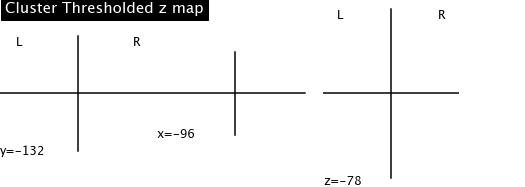

In [19]:
from IPython.display import Image
ct_list = glob.glob(os.path.join(workflow_out_dir, "secondlevel_cluster_thresholded*.jpg"))
Image(filename=ct_list[0])

## Multiple Comparison

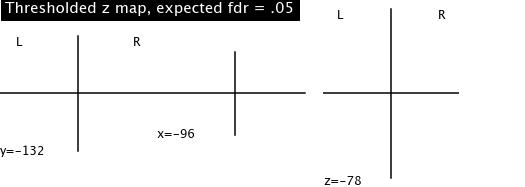

In [20]:
mc_list = glob.glob(os.path.join(workflow_out_dir, "secondlevel_multiple_comp*.jpg"))
Image(filename=mc_list[0])

## Paramatric Test

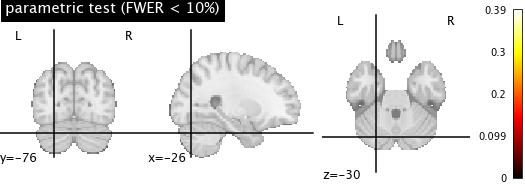

In [21]:
pt_list = glob.glob(os.path.join(workflow_out_dir, "secondlevel_paramatric*.jpg"))
Image(filename=pt_list[0])

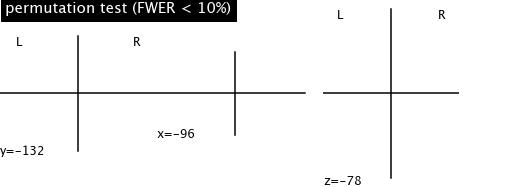

In [22]:
npt_list = glob.glob(os.path.join(workflow_out_dir, "secondlevel_permutation*.jpg"))
Image(filename=npt_list[0])